<a href="https://colab.research.google.com/github/Weizhuo-Zhang/ML_coursera/blob/master/hands_on_ML/3_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. 分类

## MNIST

In [0]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', cache=False)

一般而言，由 **`sklearn`** 加载的数据集有着相似的字典结构，这包括：

- `DESCR` 键描述数据集
- `data` 键存放一个数组，数组的一行表示一个样例，一列表示一个特征
- `target` 键存放一个标签数组

**注意：**fetch_mldata已经失效了。

In [2]:
mnist.DESCR

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [3]:
mnist.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
mnist.target

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [5]:
import numpy as np

X, y = mnist.data, mnist.target
y = y.astype(np.int8)
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


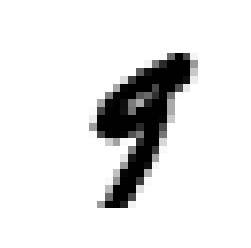

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
y[36000]

9

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [0]:
#打乱训练集
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 训练一个二分类器

In [0]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

 用随机梯度下降分类器`SGD`，使用 **`Scikit-Learn`** 的
`SGDClassifier` 类。这个分类器有一个好处是能够高效地处理非常大的数据集。这部分原因在于`SGD`一次只处理一条数据,这也使得 `SGD` 适合在线学习(online learning)。

In [11]:
from sklearn.linear_model  import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

## 对性能的评估
### 使用交叉验证测量准确性

In [12]:
# cross_val_score()
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = (y_train_5[train_index])
  X_test_fold = X_train[test_index]
  y_test_fold = (y_train_5[test_index])
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.966
0.95445
0.8827


In [0]:
# 使用cross_val_score()来评估SGDClassifier

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.966  , 0.95445, 0.8827 ])

In [0]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9089 , 0.9111 , 0.90895])

## 混淆矩阵

大体思路是:输出类别A被分类成类别 B 的次数。举个例子,为了知道分类器将 5 误分为 3 的次数,你需要查看混淆矩阵的第五行第三列。

In [0]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

就像 `cross_val_score()` , `cross_val_predict()` 也使用 K 折交叉验证。它不是返回一个评估分数,而是返回基于每一个测试折做出的一个预测值。这意味着,对于每一个训练集的样例,你得到一个干净的预测(“干净”是说一个模型在训练过程当中没有用到测试集的数据)。

现在使用测类( `confusion_matrix()` 函数,你将会得到一个混淆矩阵。传递目标类( `y_train_5` )和预测类( `y_train_pred` )给它。

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[51388,  3191],
       [  746,  4675]])

$$precision = \frac {TP} {TP + FP}$$

$$recall(TPR) = \frac {TP} {TP + FN}$$

### Precision and Recall

In [19]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.5943300279684719
0.8623870134661502


通常结合准确率和召回率会更加方便,这个指标叫做“F1 值”,特别是当你需要一个简单的方法去比较两个分类器的优劣的时候。F1 值是准确率和召回率的调和平均。普通的平均值平等地看待所有的值,而调和平均会给小的值更大的权重。所以,要想分类器得到一个高的 F1值,需要召回率和准确率同时高。

$$F1 = \frac {2} {\frac {1} {precision} + \frac {1} {recall}} = 2 * \frac {precision * recall} {precision + recall} = \frac {TP} {TP + \frac {FN + FP} {2}}$$

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7036953413110558

### Precision/Recall之间的折中

**`Scikit-Learn`** 不让你直接设置阈值,但是它给你提供了设置决策分数的方法,这个决策分数可以用来产生预测。它不是调用分类器的 `predict()` 方法,而是调用 `decision_function()` 方法。这个方法返回每一个样例的分数值,然后基于这个分数值,使用你想要的任何阈值做出预测。

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[-14014.78676649]
[False]


In [22]:
threshold = -20000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

你需要再次使用 `cross_val_predict()` 得到每一个样例的分数值,但是这一次指定返回一个决策分数,而不是预测值。

In [0]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

现在有了这些分数值。对于任何可能的阈值,使用
 `precision_recall_curve()`,你都可以计算准确率和召回率:

In [0]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

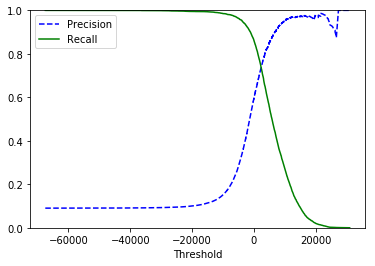

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1],"g-", label="Recall")
  plt.xlabel("Threshold")
  plt.legend(loc="upper left")
  plt.ylim([0, 1])
  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

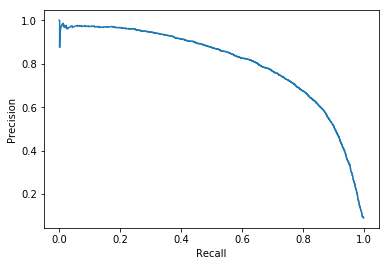

In [26]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [27]:
y_train_pred_90 = (y_scores > 7000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.903525765207284
0.4301789337760561


### ROC 曲线

ROC曲线是TPR和FPR的曲线。$FPR = 1 - TNR$

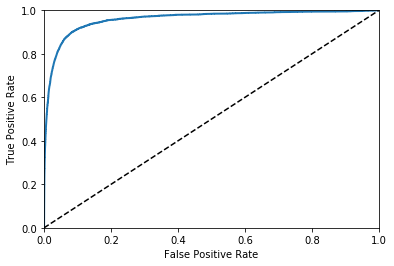

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

一个好的分类器的 ROC 曲线应该尽可能远离这条线(即向左上角方向靠拢)。

一个比较分类器之间优劣的方法是:测量ROC曲线下的面积(AUC)。一个完美的分类器的 ROC AUC 等于 1,而一个纯随机分类器的 ROC AUC 等于 0.5。Scikit-Learn 提供了一个函数来计算 ROC AUC:

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9601362962921504

优先使用 PR 曲线当正例很少,或者当你关注假正例多于假反例的时候。其他情况使用 ROC 曲线。举例子,回顾前面的 ROC 曲线和 ROC AUC 数值, 你或许认为这个分类器很棒。但是这几乎全是因为只有少数正例(“是 5”),而大部分是反例(“非 5”)。相反,PR 曲线清楚显示出这个分类器还有很大的改善空间(PR 曲线应该尽可能地靠近右上角)。

让我们训练一个 `RandomForestClassifier` ,然后拿它的的ROC曲线和ROC AUC数值去跟 `SGDClassifier`的比较。首先你需要得到训练集每个样例的数值。但是由于随机森林分类器  `RandomForestClassifier`  不提供 `decision_function()` 方法。相反，它提供了`predict_proba()` 方法。**`Scikit-Learn`** 分类器通常二者中的一个。 `predict_proba()` 方法返回一个数组，数组的每一行代表一个样例，每一列代表一个类。数组当中的值的意思是:给定一个样例属于给定类的概率。比如,70%的概率这幅图是数字 5。

In [30]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Label只分了两类，5 和 非5，因此只有两列。

In [32]:
print(y_probas_forest.shape)
print(y_probas_forest)

(60000, 2)
[[1.  0. ]
 [1.  0. ]
 [0.3 0.7]
 ...
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]]


/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


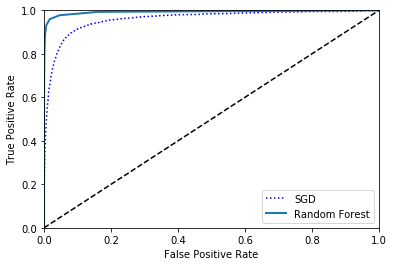

In [33]:
plt.plot(fpr,tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

如你所见， `RandomForestClassifier` 的 `ROC` 曲线比 `SGDClassifier` 的好得多：它更靠近左上角。所以，它的 `ROC AUC` 也会更大。

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9929671626173602

## 多类分类

### One vs All (OvA)

创建一个可以将图片分成 10 类（从 0 到 9）的系统的一个方法是：训练10个二分类器，每一个对应一个数字（探测器 0，探测器 1，探测器 2，以此类推）。然后当你想对某张图片进行分类的时候，让每一个分类器对这个图片进行分类，选出决策分数最高的那个分类器。这叫做“一对所有”（OvA）策略（也被叫做“一对其他”）。

**`Scikit-Learn`** 可以探测出你想使用一个二分类器去完成多分类的任务，它会自动地执行 `OvA`（除了 `SVM` 分类器，它使用 `OvO`）。让我们试一下 `SGDClassifier`

In [35]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=int8)

很容易。上面的代码在训练集上训练了一个 `SGDClassifier` 。这个分类器处理原始的目标 `class`，从 `0` 到 `9`（ `y_train` ），而不是仅仅探测是否为 `5` （ `y_train_5` ）。然后它做出一个判断（在这个案例下只有一个正确的数字）。在幕后，**`Scikit-Learn`** 实际上训练了 `10` 个二分类器，每个分类器都产到一张图片的决策数值，选择数值最高的那个类。

为了证明这是真实的，你可以调用 `decision_function() 方法。不是返回每个样例的一个数值，而是返回 `10` 个数值，一个数值对应于一个类。

In [36]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-39773.8431755 , -18260.9720118 , -20050.89786047,
         -1446.1656152 ,  -2089.79668138,  -5052.69255581,
        -29983.45135975,  -9040.3220321 ,  -5557.85778773,
         -2694.88111697]])

In [37]:
# 最高数值应该对应于类别3
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
print(sgd_clf.classes_[3])

3
[0 1 2 3 4 5 6 7 8 9]
3


### One vs One (OvO)

一个分类器用来处理数字 0 和数字 1，一个用来处理数字 0 和数字 2，一个用来处理数字 1 和 2，以此类推。这叫做“一对一”（OvO）
策略。如果有 N 个类。你需要训练 $N*(N-1)/2$ 个分类器。对于 MNIST 问题，需要训练 45 个二分类器！当你想对一张图片进行分类，你必须将这张图片跑在全部45个二分类器上。然后看哪个类胜出。

如果你想强制 **`Scikit-Learn`** 使用 OvO 策略或者 OvA 策略，你可以使用 `OneVsOneClassifier` 类或者 `OneVsRestClassifier` 类。创建一个样例，传递一个二分类器给它的构造函数。举例子，下面的代码会创建一个多类分类器，使用 OvO 策略，基于 `SGDClassifier` 。

In [38]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[9]
45


In [39]:
# 训练一个 RandomForestClassifier 同样简单
forest_clf.fit(X_train, y_train)
print(forest_clf.predict([some_digit]))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[9]


这次 **`Scikit-Learn`** 没有必要去运行 OvO 或者 OvA，因为随机森林分类器能够直接将一个样例分到多个类别。你可以调用 `predict_proba()` ，得到样例对应的类别的概率值的列表：

In [40]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

现在当然你想评估这些分类器。像平常一样，你想使用交叉验证。让我们用 `cross_val_score()` 来评估 `SGDClassifier` 的精度。

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86557688, 0.839992  , 0.87473121])

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy"))

## 误差分析

In [0]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

使用 Matplotlib 的 matshow() 函数，将混淆矩阵以图像的方式呈现。

In [0]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

这个混淆矩阵看起来相当好，因为大多数的图片在主对角线上。在主对角线上意味着被分类正确。

让我们关注仅包含误差数据的图像呈现。首先你需要将混淆矩阵的每一个值除以相应类别的图片的总数目。这样子，你可以比较错误率，而不是绝对的错误数（这对大的类别不公平）。

In [0]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

现在让我们用 0 来填充对角线。这样子就只保留了被错误分类的数据。让我们画出这个结果。

In [0]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

分析独特的误差，是获得关于你的分类器是如何工作及其为什么失败的洞见的一个好途径。但是这相对难和耗时。举例子，我们可以画出数字 3 和 5 的例子

In [0]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], ../images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], ../images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], ../images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], ../images_per_row=5)
plt.show()

## 多标签分类

比方说，这个分类器被训练成识别三个人脸，Alice，Bob，Charlie；然后当它被输入一张含有 Alice 和 Bob 的图片，它应该输出 $[1, 0, 1]$ （意思是：Alice 是，Bob 不是，Charlie 是）。这种输出多个二
值标签的分类系统被叫做多标签分类系统。

In [0]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf.KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

这段代码创造了一个 `y_multilabel` 数组，里面包含两个目标标签。第一个标签指出这个数字是否为大数字（7，8 或者 9），第二个标签指出这个数字是否是奇数。接下来几行代码会创建一个 `KNeighborsClassifier` 样例（它支持多标签分类，但不是所有分类器都可以），然后我们使用多目标数组来训练它。现在你可以生成一个预测，然后它输出两个标签：

In [0]:
print(knn_clf.predict([some_digit]))

下面的代码计算全部标签的平均 F1 值：

In [0]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
print(f1_score(y_train, y_train_knn_pred, average="macro"))

这里假设所有标签有着同等的重要性，但可能不是这样。特别是，如果你的 Alice 的照片比Bob 或者 Charlie 更多的时候，也许你想让分类器在 Alice 的照片上具有更大的权重。一个简单的选项是：给每一个标签的权重等于它的支持度（比如，那个标签的样例的数目）。为了
做到这点，简单地在上面代码中设置 average="weighted" 。

## 多输出分类

“多输出-多类分类”（或者简称为多输出分类）。

让我们从 **`MNIST`** 的图片创建训练集和测试集开始，然后给图片的像素强度添加噪声，这里是用 **`NumPy`** 的 `randint()`` 函数。目标图像是原始图像。

In [0]:
noise = rnd.randint(0, 100, (len(X_train), 784))
noise = rnd.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [0]:
# 清洁图片
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_digit]])
plot_digit(clean_digit)